**Curso**: Deep Learning


[Stephy Riega](mailto:sriega@uchicago.edu)

[Pontificia Universidad Católica del Perú](https://www.pucp.edu.pe/)  
[Laboratorio de Inteligencia Artificial y Métodos Computacionales en Ciencias Sociales](https://qlab.pucp.edu.pe/formacion-continua)

Image Super Resolution
En esta sesión vamos a ver los siguientes temas:
- Construir redes neuronales para *Image Super Resolution*
- Comparacion con métodos tradicionales

Asimismo, vamos a realizar los siguientes experimentos:
1. Usar una combinación diferente de funcion de perdida
2. Modificar parametro de las diferentes que componen las capas

Adicionalmente, intentaremos describir el espacio codificado de estos experimentos.

# Mount Your Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
!ls '/content/drive/MyDrive/Colab Notebooks/classical_SR_datasets'

BSDS100  BSDS200  General100  historical  manga109  Set14  Set5  T91  urban100


#Image Super Resolution using Autoencoders :Training your own Super Resolution AI

Este laboratorio presenta una súper resolución basada en IA para imágenes que mejora los métodos existentes que no son de IA.

## What is a *low quality* image

Una imagen de *baja calidad* a menudo se caracteriza por una baja resolución del sensor. Cuando se toma una foto con un teléfono móvil económico, a menudo se ve pixelada y carece de todo tipo de detalles que conforman una imagen rica y detallada.

**Durante esta lección, nos centraremos en este tipo de degradación, que son las imágenes pixeladas de baja resolución.**

## ¿Cómo mejorar una imagen de *baja calidad*?

A lo largo de los años, se han desarrollado muchos métodos. Estos van desde métodos de interpolación suave hasta desconvolución. Si bien dan resultados aceptables, estos métodos a menudo se basan en algunas suposiciones ingenuas. A veces, estas suposiciones solo se adaptan a un determinado tipo de entorno y no funcionarán en un caso general. Los métodos **basados en IA** intentan tener una visión más general de tales problema. En concreto, presentaremos Autoencoders que son una solución a este problema basados en Redes Neuronales Artificiales.

# Autoencoders (definicion)

Un autoencoder está hecho principalmente de:

* **Un encoder**
* **Una loss function**
* **El decoder**


## ¿Qué tipo de datos manipula un Autoencoder?

Un autoencoder codifica los datos en un espacio de funciones más pequeño, pero para descubrir cómo construir nuestro espacio, la red necesita comprender lo que queremos que haga.

De hecho, un Autoencoder es un tipo de compresión con pérdida que aprovechamos. Y aquí "*loss*" no significa "*pérdida de detalles*", de hecho solo significa que perdemos información sobre la imagen original. Aprovechamos eso para decirle a la red que reconstruya la imagen con más detalles, lo que significa que "perdimos" la información de la imagen de baja calidad y reconstruimos una nueva imagen más nítida.

**ALGO DE LOSS FUNCTION**

## ¿Cómo puede un Autoencoder aprender a hacer eso?

Necesita encontrar un patrón entre pares diferentes de baja/alta resolución e intente agregar más detalles a sus imágenes de entrada. Esto significa que tendrás que mostrarle muchas imágenes diferentes para decirle *"Oye, esa es una imagen de baja resolución y así es como se vería en alta resolución, ¿entiendes?"*

Veremos cómo poner eso en práctica a continuación, pero antes necesitamos crear nuestra red.

# Experimentos

A partir de esta parte comenzaremos a crear modificaciones del modelo original para poder probar los diferentes experimentos mencionados anteriormente:

  1. Usar una combinación diferente de funcion de perdida
  2. Modificar parametro de las diferentes que componen las capas

Realizaremos estos cambios con el proposito de optimizar el modelo original (hipotesis), es decir, obtener imagenes con mejor resolucion. Asimismo, buscaremos describir y entender el espacio codificado que nos presente estas evaluaciones. En este sentido, las modificaciones que haremos, de acuerdo a la descripcion de los experimentos respectivamente, seran:

  1. Usaremos la funcion SSIM de perdida en vez de la cambinacion de MSE y HEFNN que presenta el modelo original. Esperamos que este funcion de perdida mejore el rendimiento del modelo ya que considera la calidad de la imagen. Como hemos visto en el modelo original, tomar en cuenta una metrica diferente al MSE puede ser beneficioso.
  2. Modificaremos una capa Max Pooling que pertenece a un bach de capas convolusionales de tal manera que los parametros no se reduciran, pero si la manera en la que se procesan dentro del modelo.

Para el primer experimento, entrenaremos el modelo con su estructura igual y a base de MSE+HEFNN como metrica, guardando los pesos de esta primera parte y usandolos luego para evaluar al modelo con esta nueva funcion de perdida.

Para el segundo experimento, creamos un nuevo modelo en el cual se realice la modificacion respectiva de la capa Max Pooling. Sin embargo, tambien sera posible guardar los parametros ya que este cambio no significara un cambio relevante en la estructura del output del entrenamiento.

Nuevamente, estas modificaciones tienen la hipotesis de que el resultado implicara una mejora en el rendimiento del modelo en la parte de evaluacion.

## El encoder

Diseñar una red neuronal es algo que necesita prueba y error para hacerlo bien.

Aquí diseñaremos el siguiente Encoder:

### Encoder Code

Ejecutando el código completo a continuación, podremos ver el encoder completo del modelo original.

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

#Paremetros
n = 128
chan = 3


#Modelo original
input_img = Input(shape=(n, n, chan),name='Input')
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l1')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l2')(l1)
l3 = MaxPooling2D(padding='same',name='l3')(l2)
l3 = Dropout(0.3,name='dropout_l3')(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l4')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l5')(l4)
l6 = MaxPooling2D(padding='same',name='l6')(l5)
l6 = Dropout(0.5,name='dropout_l6')(l6)
encoded = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l7')(l6)
encoder = Model(input_img, encoded)

#Experiemento 2 : modificacion de la tasa de dropout
input_img_2 = Input(shape=(n, n, chan),name='Input_2')
l1_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l1_2')(input_img_2)
l2_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l2_2')(l1_2)
l3_2 = MaxPooling2D(padding='same',name='l3_2')(l2_2)
l3_2 = Dropout(0.3,name='dropout_l3_2')(l3_2)
l4_2 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l4_2')(l3_2)
l5_2 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l5_2')(l4_2)
l6_2 = MaxPooling2D(padding='same',name='l6_2')(l5_2)
#Modificacion de 0.5 a 0.4
l6_2 = Dropout(0.4,name='dropout_l6_2')(l6_2)
encoded_2 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l7_2')(l6_2)
encoder_2 = Model(input_img_2, encoded_2)


In [5]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l1 (Conv2D)                          │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l2 (Conv2D)                          │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l3 (MaxPooling2D)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_l3 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l4 (Conv2D)                          │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l5 (Conv2D)                          │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l6 (MaxPooling2D)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_l6 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l7 (Conv2D)                          │ (None, 32, 32, 256)         │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,328 (2.12 MB)

 Trainable params: 555,328 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Como pueden ver, existen muchos parámetros entrenables (555,328) que necesitarán ser calculados. Estos seran los que se quedaran constantes con respecto al modelo original en el experimento 1 (modificacion de la funcion de perdida) pero no para el experimento 2 (modificacion del modelo) ya que este - al ser parte del entrenamiento - cambiara los pesos estimados (no el numero de pesos estimados como podermos ver en la descripcion de ambos modelos.

In [6]:
encoder_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_2 (InputLayer)                 │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l1_2 (Conv2D)                        │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l2_2 (Conv2D)                        │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l3_2 (MaxPooling2D)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_l3_2 (Dropout)               │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l4_2 (Conv2D)                        │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l5_2 (Conv2D)                        │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l6_2 (MaxPooling2D)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_l6_2 (Dropout)               │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ l7_2 (Conv2D)                        │ (None, 32, 32, 256)         │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,328 (2.12 MB)

 Trainable params: 555,328 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

## Autoencoder Network Completo

El modelo original, y el que se presenta en el experimento 1 y 2 con excepcion de la capa dropout que modificamos, tendran una estructura igual.

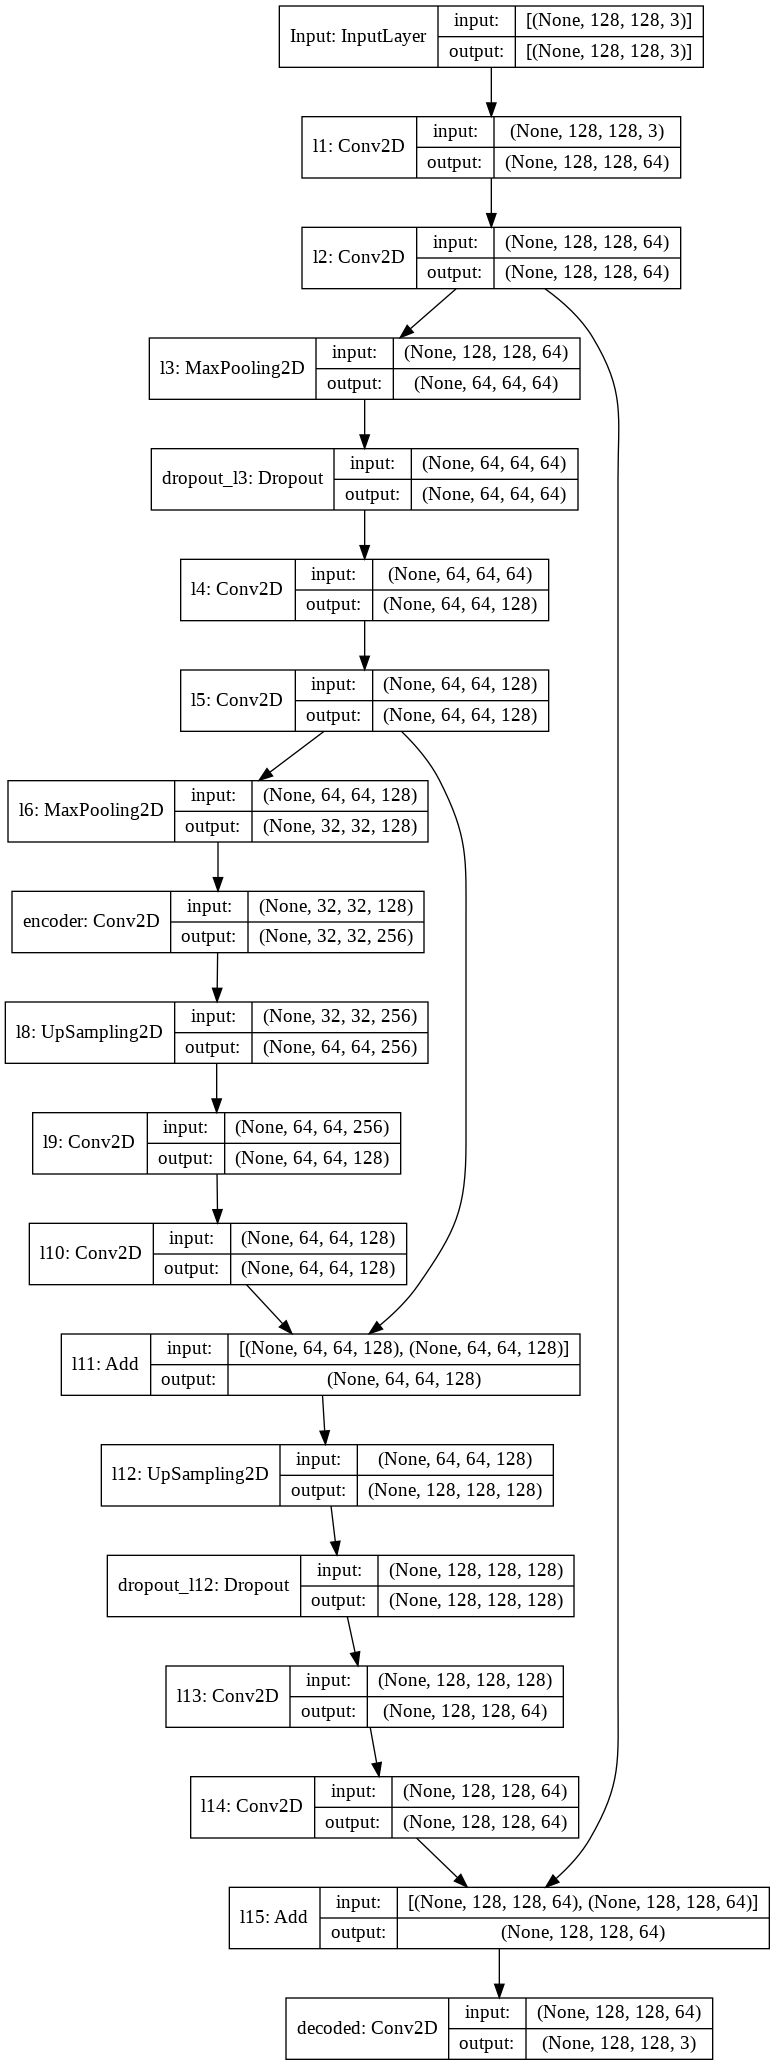

## Autoencoder Code

### Code

Here's the final network :

Tambien puedo cambiar las capas que componen al autoenconder (sin embargo no podre guardar los pesos porque tendre parametros diferentes si es que cambio alguna que determine estos, pero no presenta un problema si es que cambiamos alguna capa como maxpooling o dropout)

In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

#Modelo Original
def build_model_AE(n=128,chan=3):
    # Encoder
    input_img = Input(shape=(n, n, chan),name='Input')

    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l1')(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l2')(l1)
    l3 = MaxPooling2D(padding='same',name='l3')(l2)
    l3 = Dropout(0.3,name='dropout_l3')(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l4')(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l5')(l4)
    l6 = MaxPooling2D(padding='same',name='l6')(l5)
    l6 = Dropout(0.5,name='dropout_l6')(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l7')(l6)

    # Decoder
    l8 = UpSampling2D(name='l8')(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l9')(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l10')(l9)
    l11 = add([l5, l10],name='l11')
    l12 = UpSampling2D(name='l12')(l11)
    l12 = Dropout(0.3,name='dropout_l12')(l12)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l13')(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l14')(l13)
    l15 = add([l14, l2],name='l15')

    # chan = 3, for RGB
    decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='decoder')(l15)
    return Model(input_img, decoded),Model(input_img, l7)

# Experimento 2
def build_model_AE_2(n=128,chan=3):
    # Encoder
    input_img_2 = Input(shape=(n, n, chan),name='Input')

    l1_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l1_2')(input_img_2)
    l2_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l2_2')(l1_2)
    l3_2 = MaxPooling2D(padding='same',name='l3')(l2_2)
    l3_2 = Dropout(0.3,name='dropout_l3_2')(l3_2)
    l4_2 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l4_2')(l3_2)
    l5_2 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l5_2')(l4_2)
    l6_2 = MaxPooling2D(padding='same',name='l6')(l5_2)
    l6_2 = Dropout(0.4,name='dropout_l6_2')(l6_2)
    l7_2 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l7_2')(l6_2)

    # Decoder
    l8_2 = UpSampling2D(name='l8_2')(l7_2)
    l9_2 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l9_2')(l8_2)
    l10_2 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l10_2')(l9_2)
    l11_2 = add([l5_2, l10_2],name='l11_2')
    l12_2 = UpSampling2D(name='l12_2')(l11_2)
    l12_2 = Dropout(0.3,name='dropout_l12_2')(l12_2)
    l13_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l13_2')(l12_2)
    l14_2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='l14_2')(l13_2)
    l15_2 = add([l14_2, l2_2],name='l15_2')

    # chan = 3, for RGB
    decoded_2 = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),name='decoder_2')(l15_2)
    return Model(input_img_2, decoded_2),Model(input_img_2, l7_2)

In [8]:
# Create our network
#Modelo original
autoencoder,encoder = build_model_AE()

#Experimento 2:
autoencoder_2,encoder_2 = build_model_AE_2()

In [9]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1 (Conv2D)               │ (None, 128, 128, 64)   │          1,792 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l2 (Conv2D)               │ (None, 128, 128, 64)   │         36,928 │ l1[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l3 (MaxPooling2D)         │ (None, 64, 64, 64)     │              0 │ l2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l3 (Dropout)      │ (None, 64, 64, 64)     │              0 │ l3[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l4 (Conv2D)               │ (None, 64, 64, 128)    │         73,856 │ dropout_l3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l5 (Conv2D)               │ (None, 64, 64, 128)    │        147,584 │ l4[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l6 (MaxPooling2D)         │ (None, 32, 32, 128)    │              0 │ l5[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l6 (Dropout)      │ (None, 32, 32, 128)    │              0 │ l6[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l7 (Conv2D)               │ (None, 32, 32, 256)    │        295,168 │ dropout_l6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l8 (UpSampling2D)         │ (None, 64, 64, 256)    │              0 │ l7[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l9 (Conv2D)               │ (None, 64, 64, 128)    │        295,040 │ l8[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l10 (Conv2D)              │ (None, 64, 64, 128)    │        147,584 │ l9[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l11 (Add)                 │ (None, 64, 64, 128)    │              0 │ l5[0][0], l10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l12 (UpSampling2D)        │ (None, 128, 128, 128)  │              0 │ l11[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l12 (Dropout)     │ (None, 128, 128, 128)  │              0 │ l12[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l13 (Conv2D)              │ (None, 128, 128, 64)   │         73,792 │ dropout_l12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l14 (Conv2D)              │ (None, 128, 128, 64)   │         36,928 │ l13[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l15 (Add)                 │ (None, 128, 128, 64)   │              0 │ l14[0][0], l2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Conv2D)     

 Total params: 1,110,403 (4.24 MB)

 Trainable params: 1,110,403 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

La red final tiene aún más parámetros para entrenar, por lo que debería tomar algún tiempo para entrenar, tanto para el modelo original como el modelo para el experimento 2. Como verá, el tiempo de entrenamiento realmente depende de la cantidad de parámetros que la red tiene que entrenar (1,110,403).

Vamos a *compilar* el modelo para poder entrenarlo, y usaremos un error cuadrático medio (MSE) para la pérdida para entrenar el modelo, pero para evaluarlo en la muestra de prueba usaremos la funcion de perdida del modelo original en el experimento 2 (modificacion de la capa del modelo) y el modelo orignal,  y una nueva funcion de perdida en el experimento 1.

In [10]:
autoencoder_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_2 (Conv2D)             │ (None, 128, 128, 64)   │          1,792 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l2_2 (Conv2D)             │ (None, 128, 128, 64)   │         36,928 │ l1_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l3 (MaxPooling2D)         │ (None, 64, 64, 64)     │              0 │ l2_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l3_2 (Dropout)    │ (None, 64, 64, 64)     │              0 │ l3[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l4_2 (Conv2D)             │ (None, 64, 64, 128)    │         73,856 │ dropout_l3_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l5_2 (Conv2D)             │ (None, 64, 64, 128)    │        147,584 │ l4_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l6 (MaxPooling2D)         │ (None, 32, 32, 128)    │              0 │ l5_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l6_2 (Dropout)    │ (None, 32, 32, 128)    │              0 │ l6[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l7_2 (Conv2D)             │ (None, 32, 32, 256)    │        295,168 │ dropout_l6_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l8_2 (UpSampling2D)       │ (None, 64, 64, 256)    │              0 │ l7_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l9_2 (Conv2D)             │ (None, 64, 64, 128)    │        295,040 │ l8_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l10_2 (Conv2D)            │ (None, 64, 64, 128)    │        147,584 │ l9_2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l11_2 (Add)               │ (None, 64, 64, 128)    │              0 │ l5_2[0][0],            │
│                           │                        │                │ l10_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l12_2 (UpSampling2D)      │ (None, 128, 128, 128)  │              0 │ l11_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_l12_2 (Dropout)   │ (None, 128, 128, 128)  │              0 │ l12_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l13_2 (Conv2D)            │ (None, 128, 128, 64)   │         73,792 │ dropout_l12_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l14_2 (Conv2D)            │ (None, 128, 128, 64)   │         36,928 │ l13_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l15_2 (Add)               │ (None, 128, 128, 64)   │              0 │ l14_2[0][0],           │
│                      

 Total params: 1,110,403 (4.24 MB)

 Trainable params: 1,110,403 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del Autoencoder

In [11]:
#Modelo original
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#Experimento 2:
autoencoder_2.compile(optimizer='adam', loss='mean_squared_error')

## Cargamos los datos:

Tenemos un dataset (un subconjunto de Image Net por razones de velocidad) de imágenes que cargamos por lotes. para que no se almacene en la memoria, y entregarlo al GPU para que pueda entrenarse en una parte razonable del conjunto de datos en cada iteración.

In [12]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def load_dataset(n=128):
    images = []
    x_train_n = []
    x_train_down = []

    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset

    for root, dirnames, filenames in os.walk("/content/drive/MyDrive/Colab Notebooks/classical_SR_datasets"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    image_resized = resize(image, (n,n)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    x_train_down.append(rescale(rescale(image_resized, 0.5,channel_axis=-1), 2.0,channel_axis=-1))
                    # Rescale it 0.5x and 2x so that it is a low res image but still has 128x128 resolution
    x_train_n = np.array(x_train_n)
    x_train_down = np.array(x_train_down)
    return x_train_n, x_train_down

def get_batches(just_load_dataset=False,n=128):
    batches = 16   # Number of images to have at the same time in a batch
    batch = 0      # Number if images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0   # Batch current index
    max_batches = -1 # If you want to train only on a limited number of images to finish the training even faster.

    images = []
    x_train_n = []
    x_train_down = []

    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    for root, dirnames, filenames in os.walk("SR_dataset"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    image_resized = resize(image, (n,n)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    x_train_down.append(rescale(rescale(image_resized, 0.5,channel_axis=-1), 2.0,channel_axis=-1)) # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)

                        if just_load_dataset:
                            return x_train_n2, x_train_down2

    return x_train_n2, x_train_down2

In [13]:
es=EarlyStopping(monitor="val_loss", patience=5,
                 verbose=1,mode="auto",restore_best_weights=True)


If you wanted to train the model, that's how you'd do :

```Python
x_train_n = []
x_train_down = []
x_train_n, x_train_down = get_batches()
```

Pero solo cargaremos el modelo preentrenado ya que esto lleva mucho tiempo. Pero primero, cargaremos el conjunto de datos:

https://drive.google.com/drive/folders/1pRmhEmmY-tPF7uH8DuVthfHoApZWJ1QU

https://data.vision.ee.ethz.ch/cvl/DIV2K/

Para luego entrenar usando 200 epochs.

In [14]:
#x_train_n, x_train_down = load_dataset()
#np.save('HR',x_train_n)
#np.save('LR',x_train_down)
import numpy as np
x_train_n = np.load('HR.npy')
x_train_down = np.load('LR.npy')
x_train_n.shape
#x_train_n, x_train_down = get_batches(just_load_dataset=False)

(802, 128, 128, 3)

In [ ]:
#Modelo orignial
history_ae= autoencoder.fit(x_train_down, x_train_n,
                epochs=100,batch_size=64,verbose=1,
                shuffle=True,validation_split=0.15, callbacks=[es])

#Experimento 2:
history_ae_2= autoencoder_2.fit(x_train_down, x_train_n,
                epochs=100,batch_size=64,verbose=1,
                shuffle=True,validation_split=0.15, callbacks=[es])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - loss: 0.3028 - val_loss: 0.0687
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 451ms/step - loss: 0.0594 - val_loss: 0.0232
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - loss: 0.0281 - val_loss: 0.0158
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - loss: 0.0185 - val_loss: 0.0131
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - loss: 0.0132 - val_loss: 0.0102
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - loss: 0.0121 - val_loss: 0.0094
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5

Y aquí, cargamos los pesos ya existentes:

In [ ]:
#Modelo original
#autoencoder.save_weights("/content/drive/MyDrive/Colab Notebooks/sr.img_net.mse.final_model5.no_patch.best.weights.h5")

#Experimento 2:
#autoencoder_2.save_weights("/content/drive/MyDrive/Colab Notebooks/new_autoencoder.weights.h5")

In [15]:
#Modelo original
autoencoder.load_weights("sr.img_net.mse.final_model5.no_patch.best.weights.h5")

#Experimento 2:
autoencoder_2.load_weights("new_autoencoder.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Mostrar los resultados

Debe cargar el peso del encoder para que pueda ver la representación **encoded**:

In [16]:
#Modelo original
#encoder.save_weights('/content/drive/MyDrive/Colab Notebooks/encoder.weights.h5')
encoder.load_weights('encoder.weights.h5')

#Experimento 2:
#encoder_2.save_weights('/content/drive/MyDrive/Colab Notebooks/new_encoder.weights.h5')
encoder_2.load_weights('new_encoder.weights.h5')

Aquí, alimentamos el encoder con las imágenes de entrada sin decodificarlas para que luego podamos visualizar el resultado (y esperamos entender cómo nuestra red codificó nuestros datos...)

In [17]:
#Modelo original
encoded_imgs = encoder.predict(x_train_down)
#Experimento 2
encoded_imgs_2 = encoder_2.predict(x_train_down)

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


Como podemos ver, nuestra representación codificada tiene dimensiones extrañas. Tenemos una representación para cada imagen (256 imágenes), cada representación está en 3 dimensiones (64x64x256):

In [18]:
encoded_imgs.shape
encoded_imgs_2.shape

(802, 32, 32, 256)

Después de esto, codificamos en nuestro espacio más pequeño y luego volvemos y tenemos una imagen de súper resolución:

In [19]:
# We clip the output so that it doesn't produce weird colors
#Modelo original
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)
#Experimento 2
sr1_2 = np.clip(autoencoder_2.predict(x_train_down), 0.0, 1.0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step


En estos siguientes codigos encontraremos (de manera aleatoria):

* La imagen de entrada de baja resolución
* La imagen reconstruida
* La imagen perfecta original
* La imagen codificada
* Una versión interpolada bicúbica

In [20]:
image_index = 1


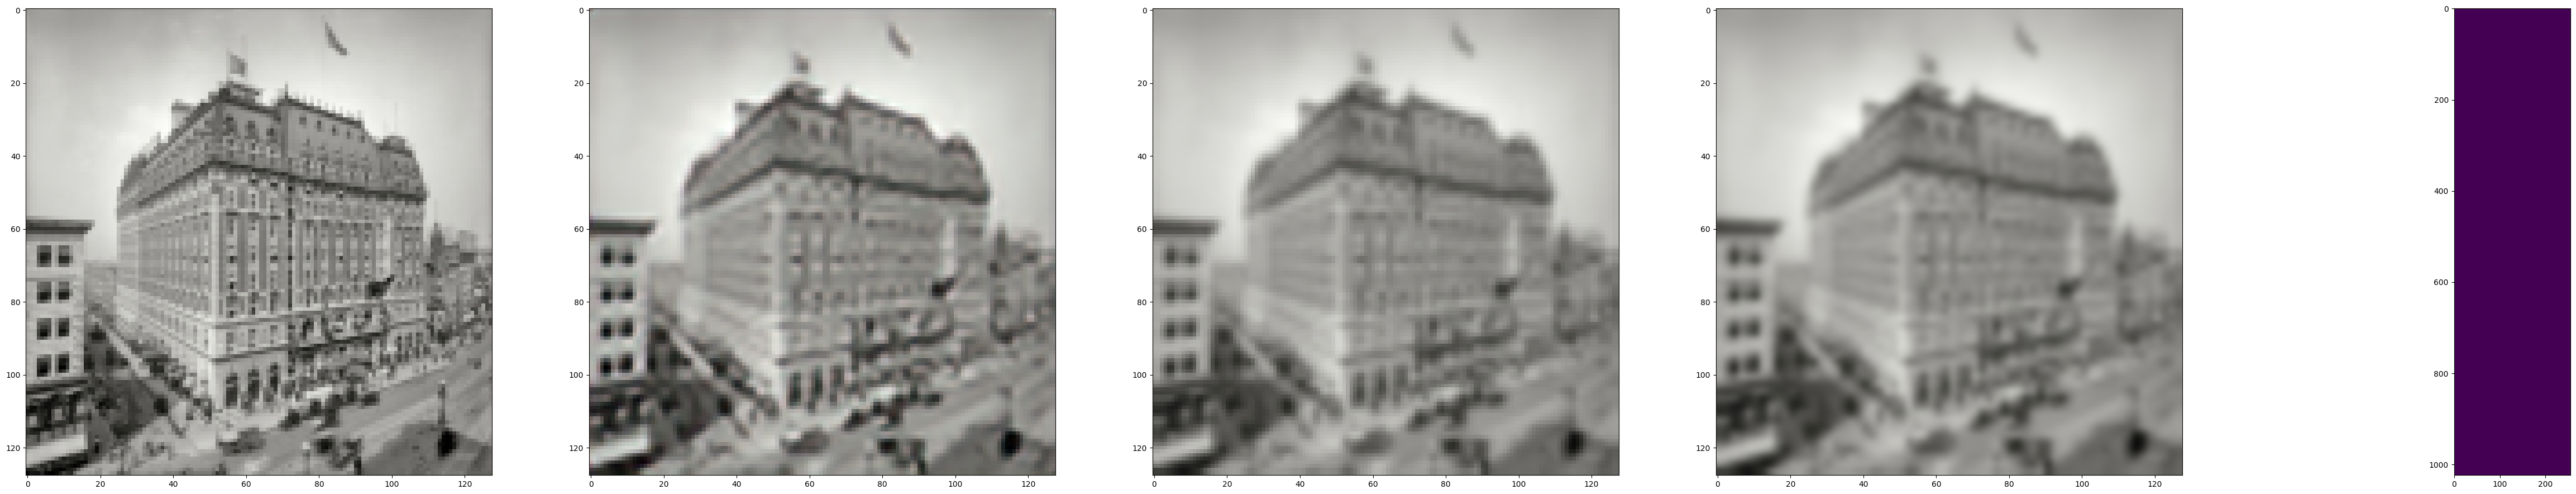

In [21]:
import matplotlib.pyplot as plt
from random import shuffle


#Modelo original
# Shuffle the pictures so there's more challenge (and you don't cheat :) )
shuffled_array = []
shuffled_array.append((x_train_down[image_index], "none"))
shuffled_array.append((x_train_down[image_index], "bicubic"))
shuffled_array.append((encoded_imgs[image_index].reshape((32*32, 256)), "none"))
shuffled_array.append((sr1[image_index], "none"))
shuffled_array.append((x_train_n[image_index], "none"))
#shuffled_array = np.array(shuffled_array)
np.random.shuffle(shuffled_array)

# Display the images
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
plt.show()

En este caso, la imagen entrada de baja resolucion, la imagen con interpolacion bicubica, la imagen original perfecta, la imagen reconstruida  y la imagen codificada.

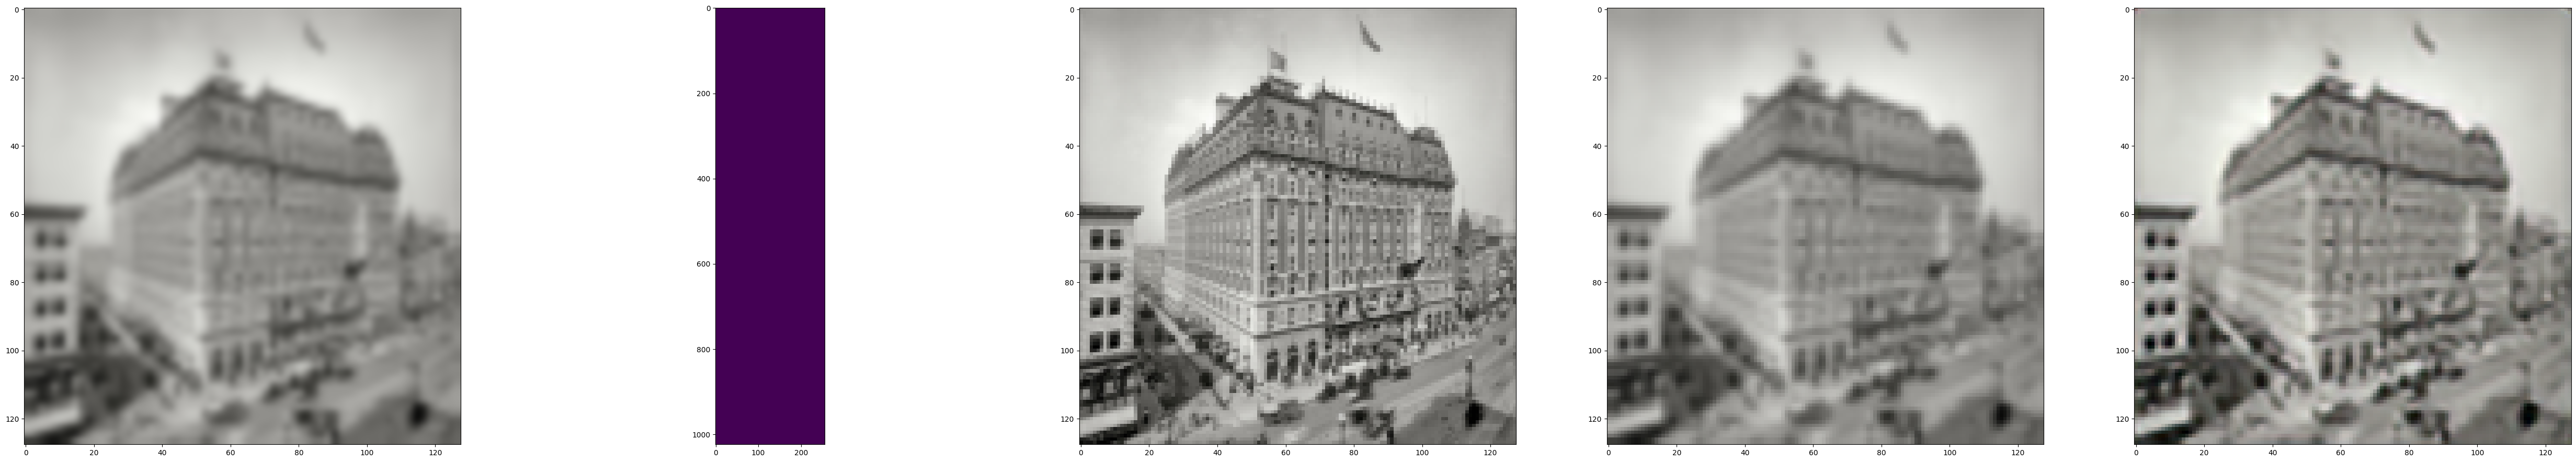

In [23]:
# Experimento 2
# Shuffle the pictures so there's more challenge (and you don't cheat :) )
shuffled_array = []
shuffled_array.append((x_train_down[image_index], "none"))
shuffled_array.append((x_train_down[image_index], "bicubic"))
shuffled_array.append((encoded_imgs_2[image_index].reshape((32*32, 256)), "none"))
shuffled_array.append((sr1_2[image_index], "none"))
shuffled_array.append((x_train_n[image_index], "none"))
#shuffled_array = np.array(shuffled_array)
np.random.shuffle(shuffled_array)

# Display the images
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(shuffled_array[i - 1][0], interpolation=shuffled_array[i - 1][1])
plt.show()

Para el Experimento 2, tenemos la imagen con interpolacion bicubica, la imagen codificada, la imagen original perfecta, la imagen entrada de baja resolucion,  la imagen reconstruida.


Si queremos los resultados sin aleatorizar el orden, nos podemos que de izquierda a derecha tenemos la imagen entrada de baja resolucion, la imagen con interpolacion bicubica, la imagen codificada, la imagen reconstruida y la imagen original perfecta para el modelo original y el experimento 2 en el respectivo orden.

###         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    - Legend :  Left (input), Mid-Left (bicubic), Mid (encoding), Mid-Right (output), Right (ground truth)

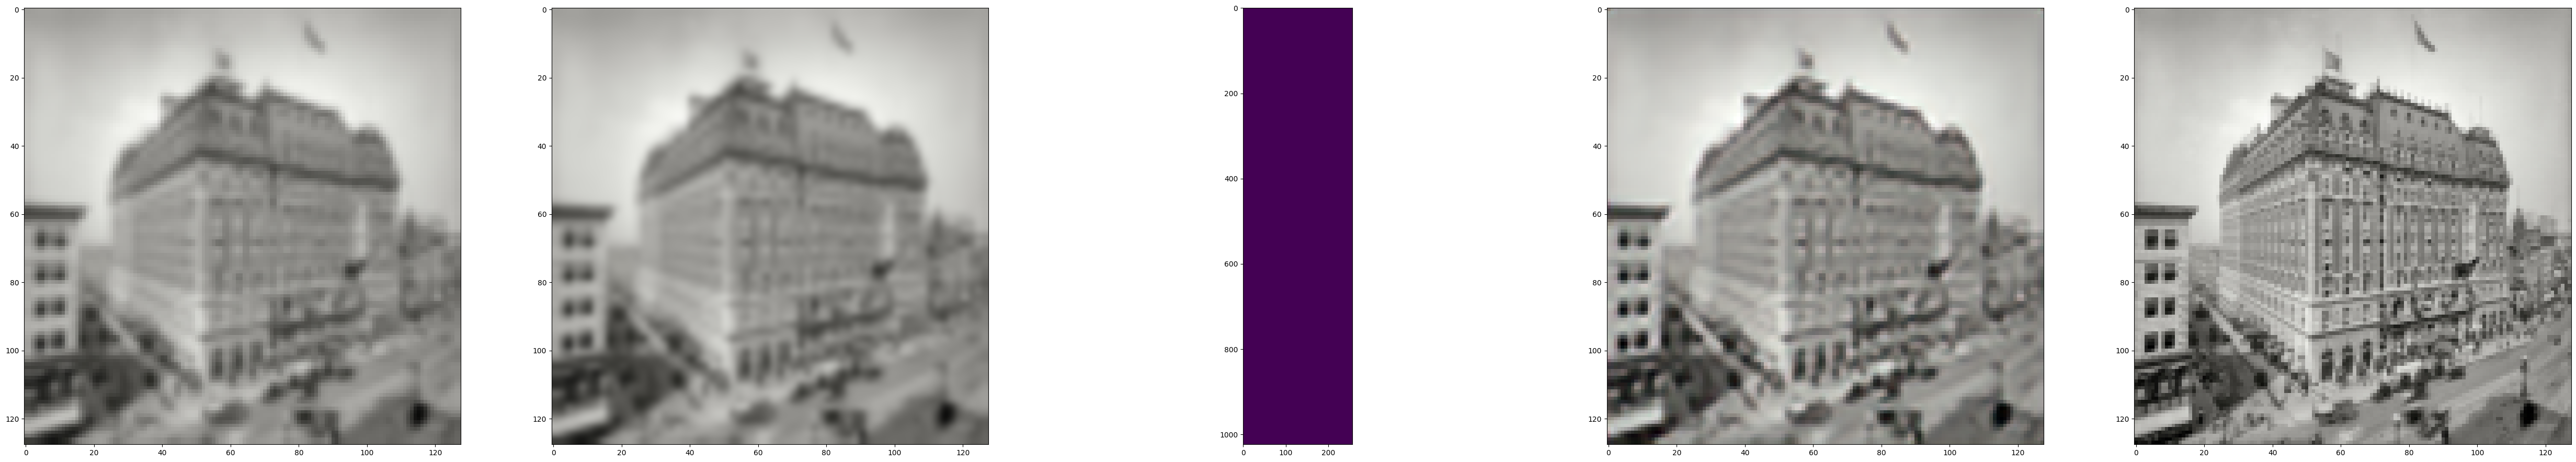

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((32*32, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

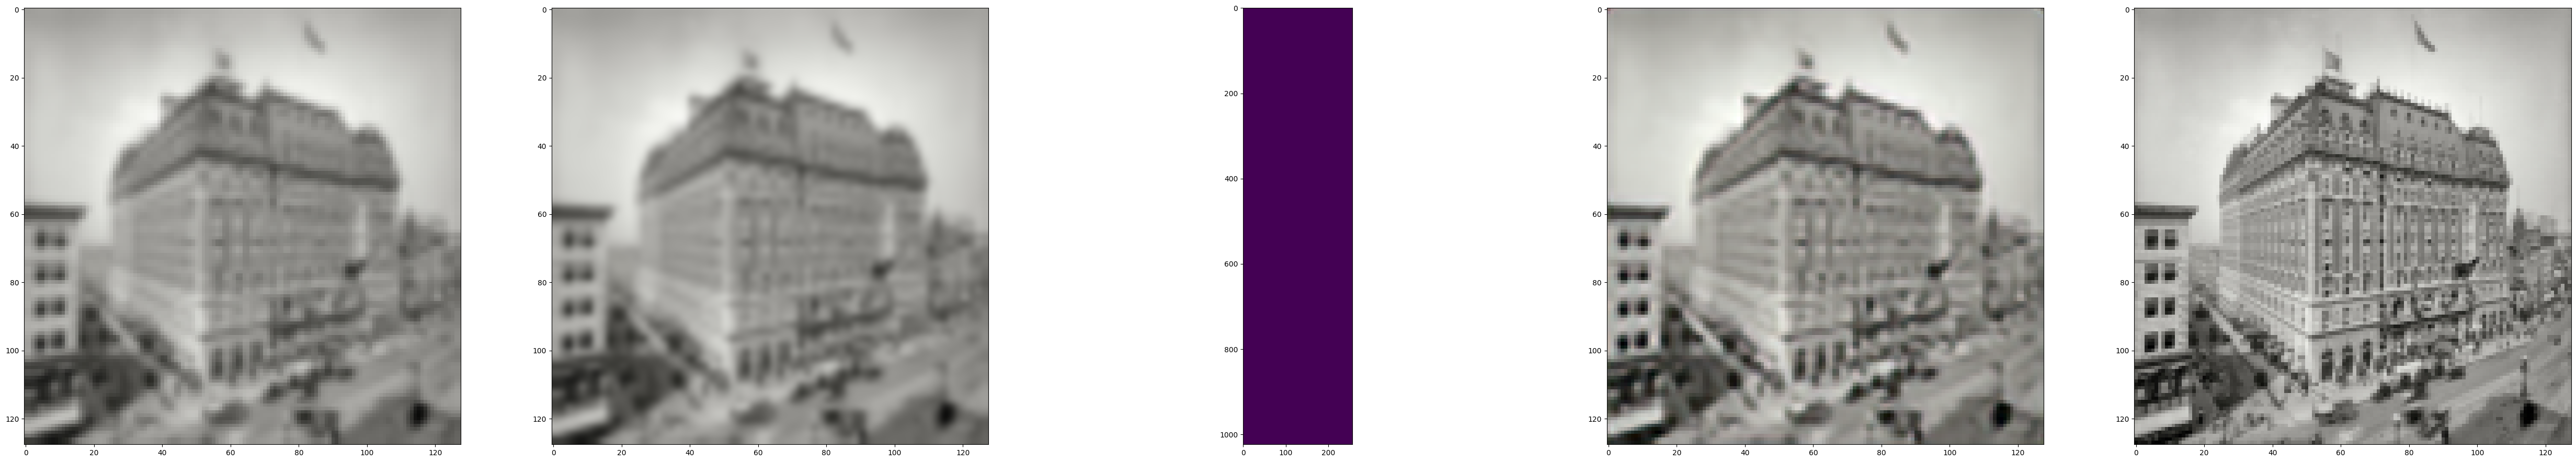

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs_2[image_index].reshape((32*32, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1_2[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

# Descripcion del espacio codificado


El espacio codificado es una representacion altamente comprimida del espacio original. Sin embargo, y a partir de un poco mas de investigacion, podemos describir y decifrar que significan algunas de estas caracteristicas.

Como podemos notar, ambos espacios codificados son muy similares: son rectangulos morados que van desde 0 a mas de 200 en el x-axis y de 1000 a 0 en el y-axis. Los rangos de ancho y altura del rectangulo nos pueden dar una idea de los pixeles de las imagenes: estos pueden ser de 200 de ancho y 1000 de alto. Asimismo, la formal de la imagen codificada (rectangular) nos puede dar a entender que la salida del enconder tiene una estructura regular y uniforme a lo largo de las activaciones. Mas aun, el color  puede significar valores bajos en la escala de activaciones. Esto es clave ya que las activaciones representan el rango de valores que toman las activaciones de las neuronas después de aplicar una función de activación en cada capa, dando pistas sobre las características extraídas de los datos de entrada.

Ahora que tenemos nuestros resultados finales, intentaremos mejorarlos mediante como medimos la calidad de imagen entre imágenes.

# Como medimos la calidad de imagen

Cambiamos las posibles funciones de perdida. Para poder distinguir dos imágenes que tienen una calidad visual y un nivel de detalle diferentes, necesitamos introducir métricas que nos ayuden a definir nuestra **función de pérdida**.

Durante estas secciones, mostraremos cómo podemos entender qué métricas nos dicen sobre la pérdida/cambio de calidad entre dos imágenes. Asimismo, escogeremos una adicional para poder implementarla usando los resultados del modelo original.

Para ello, utilizaremos este conjunto de imágenes:

In [26]:
image_index = 10

Nuevamente, puede jugar con la variable "image_index" para comparar las siguientes métricas en diferentes imágenes

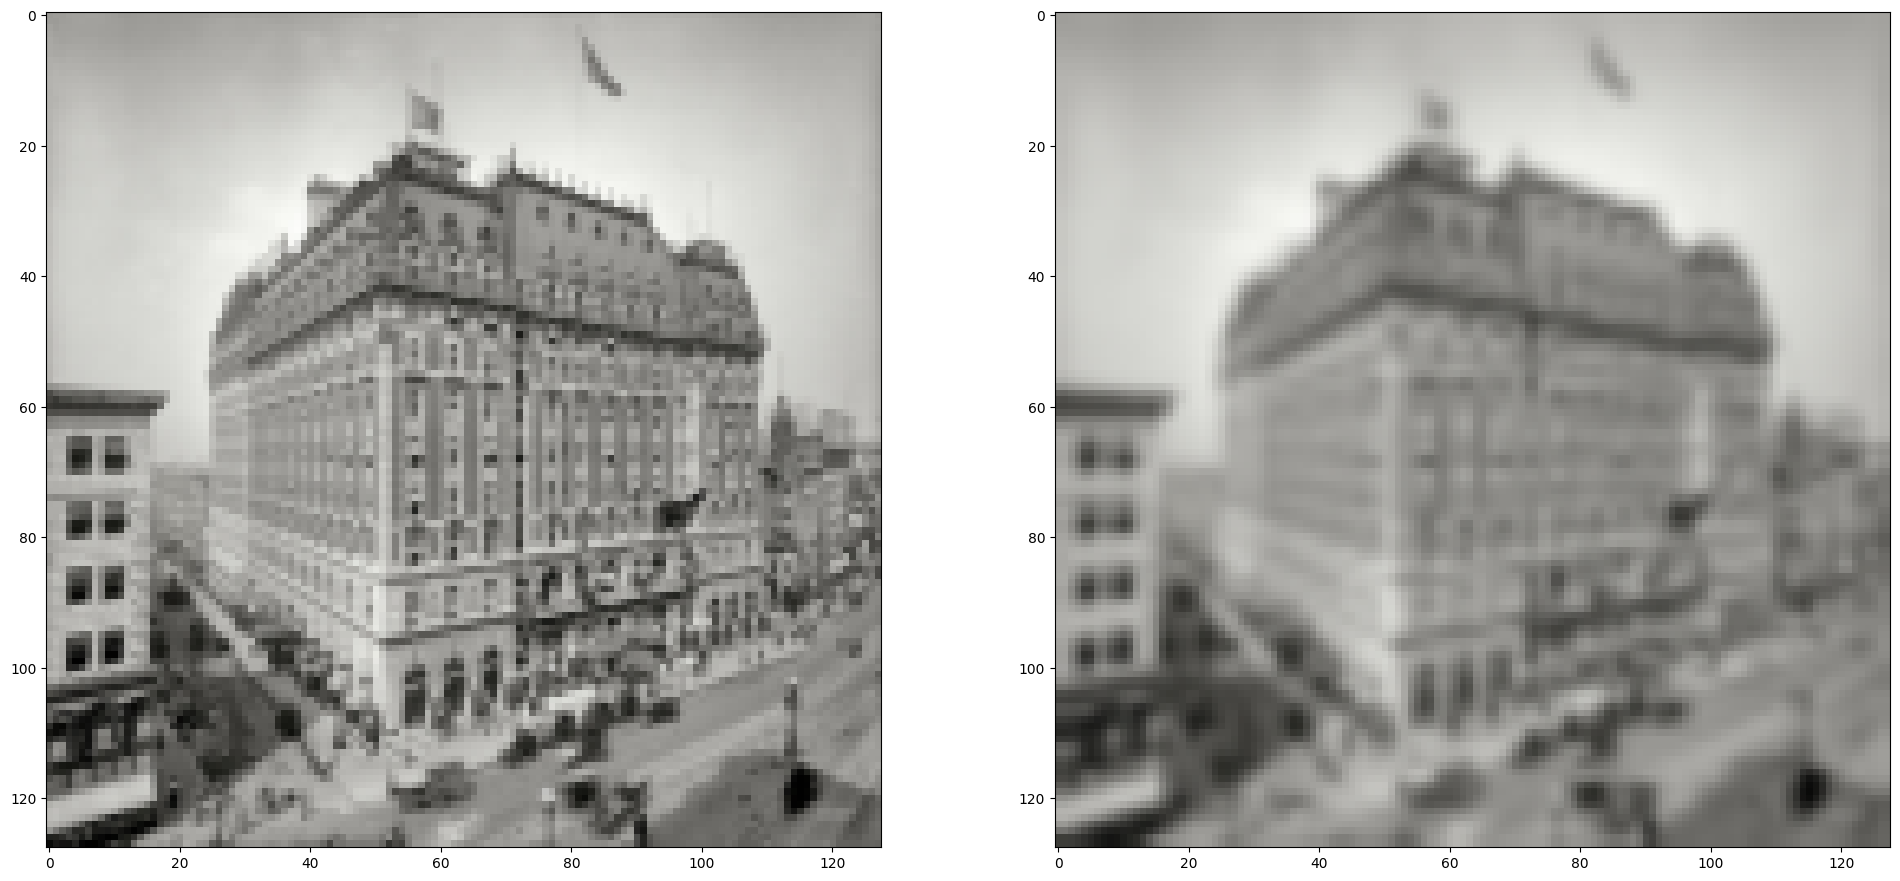

In [24]:
plt.figure(figsize=(128, 128))
i = 1

# Here, we load the images and display them
high_res = x_train_n[image_index]
low_res = x_train_down[image_index]

ax = plt.subplot(10, 10, i)
plt.imshow(high_res)
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(low_res)
plt.show()

-Legend: Left (High res), Right (Low res)

### MSE

[Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) es una métrica que indica similitud perfecta si el valor es 0. El valor crece más allá de 0 si aumenta la diferencia promedio entre las intensidades de píxeles. Sin embargo, el MSE ve la imagen desde un punto de vista muy general.

MSE tiene algunos problemas cuando se usa para la comparación de similitudes: si toma una imagen y se hace más brillante y la compara con la original, las dos imágenes serán muy diferentes según MSE, ya que una imagen oscura tiene valores de píxeles más cerca de 0 y una imagen brillante tiene un píxel más cerca de 1.

De todos modos, para nuestro propósito, comparamos imágenes de menor calidad con sus contrapartes de mayor resolución, por lo que se conserva el brillo, lo que significa que **MSE sigue siendo una métrica útil en nuestro caso**.
Mientras mas pequeno es mejor

In [25]:
def mse(orig, res):
    return ((orig - res) ** 2).mean()

In [26]:
mse(high_res, low_res)

np.float32(0.0039727665)

### SSIM

[Structural similarity (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) mide la similitud entre dos imágenes como se percibiría en un televisor o un medio similar. El SSIM es un valor en el rango $[1, -1]$ donde $1$ significaría dos imágenes idénticas y los valores más bajos mostrarían una diferencia "perceptiva".  Esta métrica compara pequeñas ventanas en la imagen en lugar de la imagen completa (como MSE), lo que la hace un poco más interesante.

Para el experimento 1, usaremos esta nueva medida de loss evaluation dado que en la similitud estructural de la imagen: contraste, luminanacia, etc. Dado que son imagenes aleatorias, priorizaremos que la calidad percibida sea buena, y esta funcion nos ayudara con ellos.

In [87]:
#!pip install scikit-image==0.15.0

In [27]:
from skimage.metrics import structural_similarity
import os
from matplotlib import pyplot

def ssim(ori, res): #!pip install scikit-image==0.15.0
    return structural_similarity(ori.astype(np.float64),
        res.astype(np.float64),
        gaussian_weights=True, data_range=1., win_size=1,
        sigma=1.5, channel_axis=-1, use_sample_covariance=False)

In [28]:
ssim(high_res, low_res)

np.float64(0.74750772855022)

### PSNR

[Peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) es una métrica definida usando el error cuadrático medio (visto arriba). Segun Wikipedia, el PSNR se usa más comúnmente para medir la calidad de la reconstrucción basada en la compresión con pérdida.

La baja resolución y la pixelización pueden considerarse una forma de *compresión* a medida que perdemos información. Cuando no hay ruido, el PSNR es infinito (porque hay una división por el MSE y el MSE es $0$ cuando ambas imágenes son exactamente iguales). Por supuesto, esto significa que necesitamos maximizar el PSNR. El resultado está en decibelios (dB).

In [29]:
from skimage.metrics import peak_signal_noise_ratio
def psnr(ori, res):
    return peak_signal_noise_ratio(ori, res, data_range=1)

In [30]:
psnr(high_res, low_res)

np.float64(24.009069742194924)

### HFENN

HFENN (High Frequency Error Norm Normalized)es la métrica que da una medida de cómo los detalles de alta frecuencia difieren entre dos imágenes. Esto significa que podemos adivinar si una imagen tiene más o menos detalles de alta frecuencia (que son detalles finos que necesitas acercar para ver y que no están borrosos) en comparación con otra imagen. Cuando el valor de salida es 0, las imágenes son idénticas. Cuanto mayor sea el valor, mayor será la diferencia perceptual en ambas imágenes.

In [31]:
import numpy as np
from scipy.ndimage import filters

def l_o_g(img, sigma):
    '''
    Laplacian of Gaussian filter (channel-wise)
    -> img: input image
    -> sigma: gaussian_laplace sigma
    <- filtered image
    '''
    while len(img.shape) < 3:
        img = img[..., np.newaxis]
    out = img.copy()
    for chan in range(img.shape[2]):
        out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)
    return out

def hfenn(orig, res):
    '''
    High Frequency Error Norm (Normalized) metric for comparison of original and result images
    The metric independent to image size (in contrast to regular HFEN)
    Inputs are expected to be float in range [0, 1] (with possible overflow)
    -> ori: original image
    -> res: result image
    <- HFENN value
    '''
    sgima = 1.5  # From DLMRI paper
    return np.mean((l_o_g(orig - res, sgima)) ** 2) * 1e4  # magnification

In [32]:
hfenn(high_res, low_res)

<ipython-input-31-737e749acc79>:15: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)


np.float32(1.1899445)

### Combinando Funciones de Perdida

En el modelo original, aparte del MSE, intentamos usar una pérdida que reconozca una mejora en detalles de alta frecuencia. HFENN mide la diferencia de detalles de alta frecuencia, y es por esto que se uso esta metrica para construir una nueva junto al MSE.

Todas las funciones de pérdidas tienen propiedades interesantes y únicas. SSIM y RMSE miden la similitud de la imagen a su manera, mientras que el PSNR mide la calidad de reconstrucción de la señal Dicho esto, cada una de estas funciones de pérdidas trae algo interesante para considerar sobre una imagen.



### Entrenamiento de una AE con MSE y HFENN

Intentemos ver qué sucede si combinamos nuestro MSE con HFENN.

Primero, debemos hacer que nuestra pérdida HFEN sea compatible con Tensorflow/Keras, así que aquí está el código:

In [33]:
import scipy.ndimage as nd
import scipy.ndimage.filters as filters

import tensorflow as tf

def hfenn_loss(ori, res):
    '''
    HFENN-based loss
    ori, res - batched images with 3 channels
    See metrics.hfenn
    '''
    fnorm = 0.325 # norm of l_o_g operator, estimated numerically
    sigma = 1.5 # parameter from HFEN metric
    truncate = 4 # default parameter from filters.gaussian_laplace
    wradius = int(truncate * sigma + 0.5)
    eye = np.zeros((2*wradius+1, 2*wradius+1), dtype=np.float32)
    eye[wradius, wradius] = 1.
    ker_mat = filters.gaussian_laplace(eye, sigma)
    with tf.name_scope('hfenn_loss'):
        chan = 3
        ker = tf.constant(np.tile(ker_mat[:, :, None, None], (1, 1, chan, 1)))
        filtered = tf.nn.depthwise_conv2d(ori - res, ker, [1, 1, 1, 1], 'VALID')
        loss = tf.reduce_mean(tf.square(filtered))
        loss = loss / (fnorm**2)
    return loss

En el modelo original, para combinar MSE y HFEN realizamos una suma ponderada (elegimos un $peso = 10$) de la siguiente manera:

$MSE + peso * HFENN$, donde $peso$ es un número real que podría ser cualquier cosa que nos convenga.



In [34]:
from keras import losses

def ae_loss(input_img, decoder):
    mse = losses.mean_squared_error(input_img, decoder) # MSE
    weight = 10.0 # weight

    return mse + weight * hfenn_loss(input_img, decoder) # MSE + weight * HFENN

In [35]:
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)  # SSIM ranges from -1 to 1, so we flip it

# Evaluacion de modelos

Vamos a evaluar los resultados del entrenamiento

In [37]:
# Modelo original
autoencoder_hfenn,encoder_hfenn = build_model_AE()

#Experimento 2
autoencoder_hfenn_2,encoder_hfenn_2 = build_model_AE_2()

In [38]:
#Experimento 1
autoencoder_ssim_1,encoder_ssim_1 = build_model_AE()

In [39]:
#Modelo original
autoencoder_hfenn.compile(optimizer='adam', loss= ae_loss, metrics=['mean_squared_error'])
es_hfenn=EarlyStopping(monitor="val_loss", patience=5,
                 verbose=1,mode="auto",restore_best_weights=True)
#Experimento 2
autoencoder_hfenn_2.compile(optimizer='adam', loss= ae_loss, metrics=['mean_squared_error'])
es_hfenn=EarlyStopping(monitor="val_loss", patience=5,
                 verbose=1,mode="auto",restore_best_weights=True)

In [40]:
#Experimento 1
autoencoder_ssim_1.compile(optimizer='adam', loss= ssim_loss, metrics=['mean_squared_error'])
es_hfenn=EarlyStopping(monitor="val_loss", patience=5,
                 verbose=1,mode="auto",restore_best_weights=True)

Pero, solo cargaremos los pesos preentrenados:

In [64]:
history = autoencoder_hfenn.fit(x_train_down, x_train_n,
                epochs=100,batch_size=64,verbose=2,
                shuffle=True,validation_split=0.15,callbacks=[es_hfenn])

Epoch 1/100
11/11 - 5s - 454ms/step - loss: 0.0070 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0019
Epoch 2/100
11/11 - 5s - 453ms/step - loss: 0.0068 - mean_squared_error: 0.0020 - val_loss: 0.0062 - val_mean_squared_error: 0.0018
Epoch 3/100
11/11 - 5s - 464ms/step - loss: 0.0068 - mean_squared_error: 0.0020 - val_loss: 0.0061 - val_mean_squared_error: 0.0018
Epoch 4/100
11/11 - 5s - 446ms/step - loss: 0.0068 - mean_squared_error: 0.0020 - val_loss: 0.0061 - val_mean_squared_error: 0.0018
Epoch 5/100
11/11 - 5s - 468ms/step - loss: 0.0067 - mean_squared_error: 0.0020 - val_loss: 0.0061 - val_mean_squared_error: 0.0018
Epoch 6/100
11/11 - 5s - 461ms/step - loss: 0.0067 - mean_squared_error: 0.0020 - val_loss: 0.0061 - val_mean_squared_error: 0.0018
Epoch 7/100
11/11 - 5s - 468ms/step - loss: 0.0067 - mean_squared_error: 0.0020 - val_loss: 0.0061 - val_mean_squared_error: 0.0018
Epoch 8/100
11/11 - 5s - 457ms/step - loss: 0.0067 - mean_squared_error: 0.0

In [48]:
history_2 = autoencoder_hfenn_2.fit(x_train_down, x_train_n,
                epochs=100,batch_size=64,verbose=2,
                shuffle=True,validation_split=0.15,callbacks=[es_hfenn])

Epoch 1/100
11/11 - 5s - 453ms/step - loss: 0.0155 - mean_squared_error: 0.0036 - val_loss: 0.0125 - val_mean_squared_error: 0.0028
Epoch 2/100
11/11 - 5s - 443ms/step - loss: 0.0146 - mean_squared_error: 0.0033 - val_loss: 0.0118 - val_mean_squared_error: 0.0026
Epoch 3/100
11/11 - 5s - 463ms/step - loss: 0.0137 - mean_squared_error: 0.0031 - val_loss: 0.0113 - val_mean_squared_error: 0.0025
Epoch 4/100
11/11 - 5s - 466ms/step - loss: 0.0129 - mean_squared_error: 0.0029 - val_loss: 0.0107 - val_mean_squared_error: 0.0024
Epoch 5/100
11/11 - 5s - 442ms/step - loss: 0.0123 - mean_squared_error: 0.0027 - val_loss: 0.0103 - val_mean_squared_error: 0.0023
Epoch 6/100
11/11 - 5s - 468ms/step - loss: 0.0118 - mean_squared_error: 0.0026 - val_loss: 0.0100 - val_mean_squared_error: 0.0022
Epoch 7/100
11/11 - 5s - 457ms/step - loss: 0.0113 - mean_squared_error: 0.0025 - val_loss: 0.0097 - val_mean_squared_error: 0.0022
Epoch 8/100
11/11 - 5s - 440ms/step - loss: 0.0110 - mean_squared_error: 0.0

In [99]:
history_1 = autoencoder_ssim_1.fit(x_train_down, x_train_n,
                epochs=100,batch_size=64,verbose=2,
                shuffle=True,validation_split=0.15,callbacks=[es_hfenn])

Epoch 1/100
11/11 - 28s - 3s/step - loss: 0.5582 - mean_squared_error: 0.0946 - val_loss: 0.2793 - val_mean_squared_error: 0.0129
Epoch 2/100
11/11 - 22s - 2s/step - loss: 0.2406 - mean_squared_error: 0.0131 - val_loss: 0.1850 - val_mean_squared_error: 0.0065
Epoch 3/100
11/11 - 10s - 926ms/step - loss: 0.1830 - mean_squared_error: 0.0070 - val_loss: 0.1660 - val_mean_squared_error: 0.0048
Epoch 4/100
11/11 - 10s - 928ms/step - loss: 0.1676 - mean_squared_error: 0.0060 - val_loss: 0.1560 - val_mean_squared_error: 0.0044
Epoch 5/100
11/11 - 10s - 932ms/step - loss: 0.1574 - mean_squared_error: 0.0058 - val_loss: 0.1485 - val_mean_squared_error: 0.0044
Epoch 6/100
11/11 - 10s - 926ms/step - loss: 0.1494 - mean_squared_error: 0.0052 - val_loss: 0.1430 - val_mean_squared_error: 0.0042
Epoch 7/100
11/11 - 10s - 924ms/step - loss: 0.1451 - mean_squared_error: 0.0052 - val_loss: 0.1399 - val_mean_squared_error: 0.0041
Epoch 8/100
11/11 - 5s - 454ms/step - loss: 0.1401 - mean_squared_error: 0.

# Resultados

En la siguiente tabla podemos resumir los resultados de los 3 modelos entrenados:

| Modelo                                             | Loss   | MSE    | Val Loss | Val MSE |
|----------------------------------------------------|--------|--------|----------|---------|
| Modelo original                                   | 0.0063 | 0.0019 | 0.0058   | 0.0017  |
| Experimento 1: cambio a función de pérdida SSIM  | 0.1145 | 0.0026 | 0.1176   | 0.0020  |
| Experimento 2: reducción de dropout de 0.5 a 0.4 | 0.0066 | 0.0020 | 0.0062   | 0.0019  |


Mas adelante examinaremos los resultados de manera practica examinando las imagenes, pero con los resultados en las metricas podemos darnos una idea de lo que encontraremos. Primero, el modelo original sigue siendo el mejor. Es decir, podemos encontrar que ni el cambio de funcion de perdida ni la reduccion del dropout ayudo a la eficiencia del modelo.

Sin embargo, el experimento 2, que hizo la reduccion del dropout, parece tener porcentajes parecidos en todas las metricas al modelo original. En un principio, esto se puede explicar dado que usa el mismo modelo y la misma funcion de perdida. El mismo argumento no se puede hacer para el experimento 1, en el cual podemos ver claras diferencias en la perdida y el val perdida, aunque esto se puede deber al cambio en la funcion de perdida y los rangos que existen. Aun asi, el valor no es cercano a 1, lo cual nos indica que el rendimiento del modelo no parece haber mejorado mucho.

In [41]:
#Modelo original
#autoencoder_hfenn.save_weights("/content/drive/MyDrive/Colab Notebooks/sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.h5")
autoencoder_hfenn.load_weights("sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.h5")

#Experimento 2
#autoencoder_hfenn_2.save_weights("/content/drive/MyDrive/Colab Notebooks/sr.img_net.mse_hfenn.final_model5_2.no_patch_2.weights.h5")
autoencoder_hfenn_2.load_weights("sr.img_net.mse_hfenn.final_model5_2.no_patch_2.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
#Experimento 1
#autoencoder_ssim_1.save_weights("/content/drive/MyDrive/Colab Notebooks/sr.img_net.mse_hfenn.final_model5_2.no_patch_1.weights.h5")
autoencoder_ssim_1.load_weights("sr.img_net.mse_hfenn.final_model5_2.no_patch_1.weights.h5")


Veamos qué puede hacer la red después de usar nuestra nueva pérdida personalizada:

In [43]:
sr_hfenn = np.clip(autoencoder_hfenn.predict(x_train_down), 0.0, 1.0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step


In [44]:
sr_hfenn_2 = np.clip(autoencoder_hfenn_2.predict(x_train_down), 0.0, 1.0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step


In [45]:
sr_ssim_1 = np.clip(autoencoder_ssim_1.predict(x_train_down), 0.0, 1.0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step


Ahora, mostraremos los resultados en las imagenes para poder darnos unos idea de como se representa visualmente estos hallazgos.

**Nota** : haz doble clic en las imágenes para hacerlas más grandes

### Display

In [46]:
sr_hfenn[image_index].shape

(128, 128, 3)

In [47]:
image_index=0
ori = x_train_n[image_index]
res = sr_hfenn[image_index]
res_1 = sr1[image_index]
mse(ori, res),mse(ori, res_1)

(np.float32(0.0066654733), np.float32(0.006837471))

el error medio cuadratico y el loss function fueron mejoradas usando una metrica adecuada

In [48]:
image_index = 10

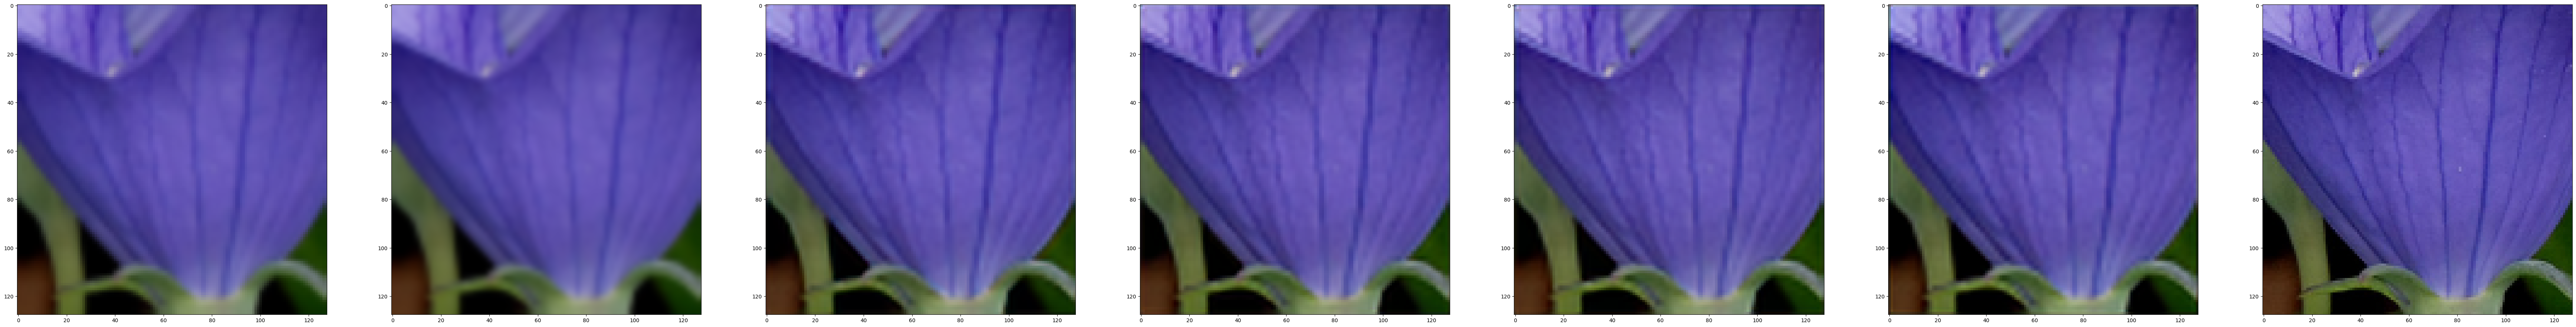

In [49]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn_2[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_ssim_1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

**Nota** : haz doble clic en las imágenes para hacerlas más grandes

El orden de derecha a izquierda nos muestra lo siguiente: el modelo modificado para ser input, aquel con modificacion bicubica, la imagen del producto del entrenamiento con MSE, la imagen del entrenamiento con MSE + HFENN, la imagen producto del experimento 2 (reduccion del dropout de 0.5 a 0.4), la imagen producto del experimento 1 (cambio a SSIM como funcion de perdida) y la imagen original real de calidad.

Si miramos de lejos la imagen, parece no existir una diferencia tan notoria entre los resultados de los expeimento 1 y 2 con el modelo original. Mas aun, no es facil identificar al input ya que es la peor de todas las imagenes, asi como a aquella con modificacion bicubica pues se nota la suavizacion, asi como la imagen original puede verse mas detallada.

Si mira un poco más de cerca y revisa las líneas y los bordes, verá que son más nítidos cuando usa MSE y HFENN en comparación con MSE solo.

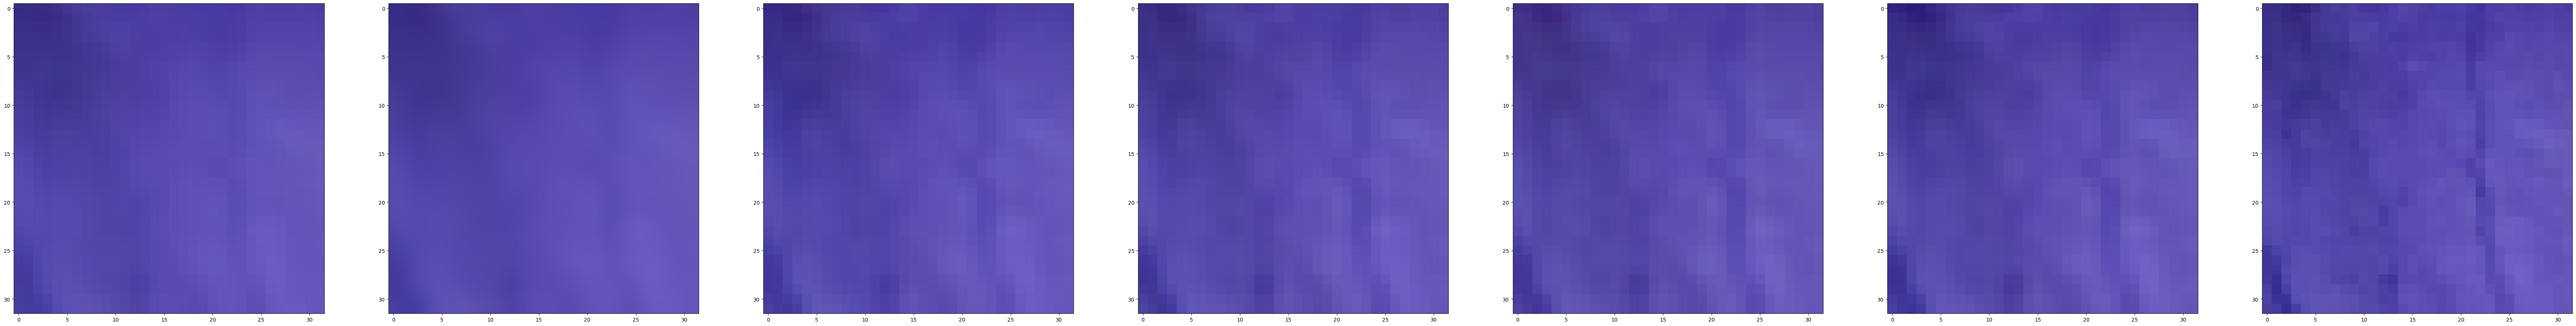

In [50]:
plt.figure(figsize=(128, 128))
j = 1
i = 1
idx_1 = 32*j
idx_2 = 32*(j+1)
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index, idx_1:idx_2, idx_1:idx_2], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn_2[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_ssim_1[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index, idx_1:idx_2, idx_1:idx_2])
plt.show()

**Nota** : haz doble clic en las imágenes para hacerlas más grandes

(El orden de derecha a izquierda nos muestra lo siguiente: el modelo modificado para ser input, aquel con modificacion bicubica, la imagen del producto del entrenamiento con MSE, la imagen del entrenamiento con MSE + HFENN, la imagen producto del experimento 2 (reduccion del dropout de 0.5 a 0.4), la imagen producto del experimento 1 (cambio a SSIM como funcion de perdida) y la imagen original real de calidad. )

Sin embargo, cuando miramos mas detenidamente, encontramos que las diferencias en los modelos. Primero, para obtener un punto de comparacion, encontramos que la imagen original presenta mas detallas en las lineas de la flor que la imagen modificada para ser output no nota tan claro, pero que las imagenes que pertenecen al modelo original con MSE or MSE+HFENN como funcion de perdida (3 y 4), asi como las que pertencen al experimento 1 y 2 (5 y 6) si rescatan en comparacion con las demas imagenes.

Entre estas imagenes en donde se vemos una mejora, podemos notar que el modelo original con MSE como funcion de perdida se pierde mas que los demas. Entre las otras imagenes restantes, las diferencias son casi nulas, siendo mas parecidas aquella que pertenece al modelo original con MSE +HEFFN y aquella que tambien usa esta metrica pero que reduce el dropout.

# Apéndice

Este notebook es basado en el tutorial de NVIDIA DEEP LEARNING INSTITUTE

<a href="https://www.nvidia.com/dli"> 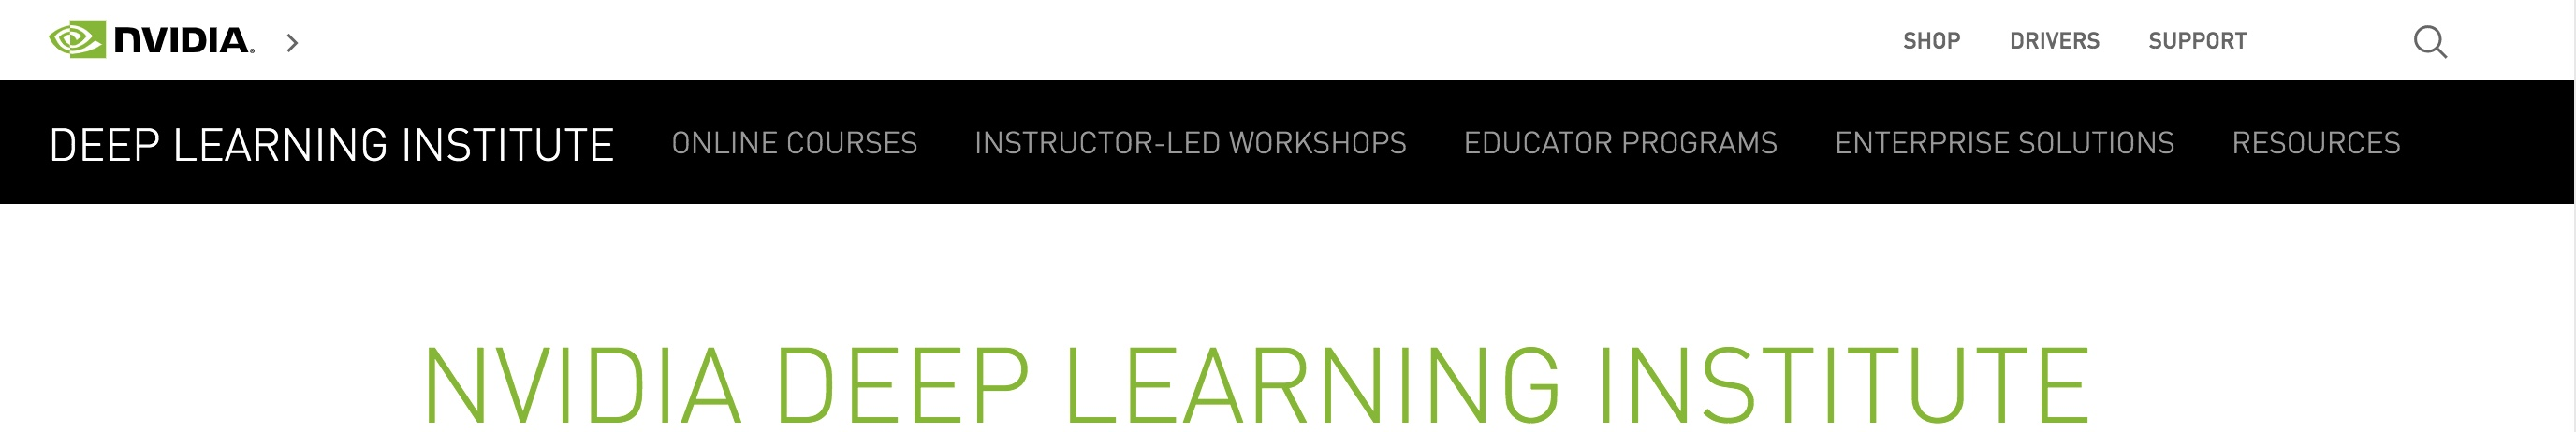 </a>

